<a href="https://colab.research.google.com/github/pfyeh1/trip_planner/blob/main/planner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install openmeteo-requests
!pip install requests_cache

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 675.4/675.4 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.4/393.4 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.1 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 25.9.23
    Uninstalling flatbuffers-25.9.23:
      Successfully uninstalled flatbuffers-25.9.23
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 5.1 MB/s eta 0:00:00


In [3]:
import os, sys
import pandas as pd
import numpy as np
import requests
import random
from io import StringIO

import requests_cache
import openmeteo_requests

from google import genai

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)

from IPython.display import Markdown

sys.path.append('/content/drive/My Drive/Colab Notebooks/utils/')

In [4]:
# set paths
gpath = os.path.join('/content','drive', 'My Drive', '_data', 'places')
os.chdir(gpath)

In [5]:
from google.colab import userdata
gplaces_api_key = userdata.get('GOOGLE_PLACES')
gemini_api_key = userdata.get('GOOGLE_GEMINI_API_KEY')

In [30]:
def genreate_text(prompt: str, model_id: str, api_key: str):
  """
  Generates respponse from text prompt
  :param prompt: str
  :param model_id: str
  :return: str
  """

  try:
    client = genai.Client(api_key = api_key)
    response = client.models.generate_content(
      model = model_id,
      contents =prompt
          )
    return response.text
  except Exception as e:
    print(f'Error occurred: {e}')
    return None

def get_lat_long(address: str, api_key: str):
  """
  Gets latitude and longitude from address
  :param address: str
  :param api_key: str
  :return: tuple (lat_long_dict, location_name)
  """
  url = 'https://maps.googleapis.com/maps/api/geocode/json?'

  params = {
      "address": address,
      "key": api_key
  }

  res = requests.get(url, params = params)

  if res.status_code == 200:
    data = res.json()
    if data['results']: # Check if the results list is not empty
      lat = data['results'][0]['geometry']['location']['lat']
      lng =  data['results'][0]['geometry']['location']['lng']
      lng_name = data['results'][0]['address_components'][0]['long_name']

      return lat, lng, lng_name
    else:
      print(f"Could not find location data for: {address}")
      return None, None, None
  else:
    print(f"Error fetching data for {address}: {res.status_code}")
    return None, None, None


def create_open_meteo_session():
  """
  Creates Open Meteo session
  :return: requests.Session
  """
  cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
  openmeteo_client = openmeteo_requests.Client(cache_session)
  return openmeteo_client

def get_historical_weather(lat: float, lng: float, start_date: str, end_date: str):
  """
  Get historical temps given a lat lng location
  :param lat: float
  :param lng: float
  :param start_date: str
  :param end_date: str
  :return: dict
  """
  url = "https://archive-api.open-meteo.com/v1/archive"
  params = {
      "latitude": lat,
      "longitude": lng,
      "start_date": start_date,
      "end_date": end_date,
      "daily": ["sunrise", "sunset", "temperature_2m_mean"],
      "temperature_unit": "fahrenheit",
      "windspeed_unit": "mph",
      "precipitation_unit": "inch",
  }

  om_client = create_open_meteo_session()
  responses = om_client.weather_api(url, params = params)
  res = responses[0]

  return res

def get_marine_weather(lat: float, lng: float):
  """
  Get current wave conditions
  :param lat: float
  :param lng: float
  :return: dict
  """
  url = "https://marine-api.open-meteo.com/v1/marine"
  params = {
      "latitude": lat,
      "longitude": lng,
      "current": ["wave_height", "swell_wave_height", "sea_surface_temperature", "wave_period", "sea_level_height_msl"],
      "length_unit": "imperial",
    }

  om_client = create_open_meteo_session()

  responses = om_client.weather_api(url, params = params)
  res = responses[0]

  current = res.Current()

  current_time = current.Time()
  current_local_time = pd.to_datetime(current_time, unit = "s", utc = True).tz_convert(timezone_str)

  current_wave_height = current.Variables(0).Value()
  current_swell_wave_height = current.Variables(1).Value()
  current_sea_surface_temperature = current.Variables(2).Value()*1.8+32
  current_wave_period = current.Variables(3).Value()
  current_sea_level_height_msl = current.Variables(4).Value()

  current_conditions_dict = {
    'time_utc_unix': int(current_time),
    'time_local': current_local_time.isoformat(),
    'wave_height': current_wave_height,
    'swell_wave_height': current_swell_wave_height,
    'sea_surface_temp': current_sea_surface_temperature,
    'wave_period_s': current_wave_period,
    'sea_level_height_msl': current_sea_level_height_msl
}
  return current_conditions_dict

# Gather User Inputs

In [33]:
# user inputs
destination = input("Pick a surf destination (e.g., Bali/Taiwan) ").lower()
start_date = input("Enter your trip start date (YYYY-MM-DD): ")
trip_duration = int(input("How many days will your trip last? "))

month_name = pd.to_datetime(start_date).strftime('%B')
end_date = pd.to_datetime(start_date) + pd.Timedelta(days = trip_duration)
end_date = end_date.strftime('%Y-%m-%d')

Pick a surf destination (e.g., Bali/Taiwan) Bali
Enter your trip start date (YYYY-MM-DD): 2026-08-01
How many days will your trip last? 5


In [34]:
planner_prompt = (f"Create a general itinerary for a {trip_duration}-day surf trip "
                    f"to {destination} in {month_name}. The travelers are a family of 4 consisting of 2 adults and 2 teenage boys."
                    "The dad and boys are between beginner and intermediate surf levels while the mom is a beginner"
                    "Low to moderate budget. For each day, suggest a specific surf spot for their "
                    "skill level, a non-surfing activity (e.g., cultural visit, hikes), and "
                    "a dinner recommendation."
                    "The surf spots shall not be more than 30 min. away from each other in terms of a drive."
                    "For each surf spot, provide the average ocean temperature in Fahrenheit for that surf spot for that month ."
                    "Keep it concise and fun."
                    "The output should be a JSON object or array that can be converted into a Pandas dataframe using pd.read_json()"
                    "The field names should all be lower case and use underscore if necessary instead of camel case."
                    "There should be 6 fields."
                    "The first field is the day number."
                    "The second field is the surf_spot."
                    f"The third field is average ocean temperature for {month_name} shall be named 'average_ocean_temperature'"
                    "The fourth field is the the non_surfing_activity."
                    "The fifth field is the dinner_recommendaiton."
                    "The 6th field shall be sources and the value are any URLs related to the other fields."
                    )


# Query Gemini to Get Travel Planner Recommendation

In [35]:
res = genreate_text(planner_prompt, "gemini-2.5-flash", gemini_api_key)

In [36]:
#res

In [37]:
res = res.removesuffix("```")
res = res.removeprefix("```json")

In [38]:
df = pd.read_json(StringIO(res))

In [39]:
df.head()

,day_number,surf_spot,average_ocean_temperature,non_surfing_activity,dinner_recommendation,sources
0,1,Kuta Beach,81,"Settle into your accommodation, explore the im...","Casual dinner at a local Warung (e.g., Warung ...",[https://seatemperature.info/bali-water-temper...
1,2,Legian Beach,81,"Visit the majestic Tanah Lot Temple, perched o...",Enjoy classic Balinese and Indonesian dishes a...,[https://seatemperature.info/bali-water-temper...
2,3,"Batu Bolong, Canggu",81,"Explore Canggu's vibrant streets, local boutiq...",Savor delicious and affordable local Indonesia...,[https://seatemperature.info/bali-water-temper...
3,4,"Berawa Beach, Canggu",81,Participate in a hands-on Balinese cooking cla...,Indulge in sizzling pork ribs and enjoy the li...,[https://seatemperature.info/bali-water-temper...
4,5,"Batu Bolong, Canggu",81,"Enjoy some last-minute souvenir shopping, revi...",A relaxed farewell dinner at a family-friendly...,[https://seatemperature.info/bali-water-temper...


In [40]:
os.getcwd()

'/content/drive/MyDrive/_data/places'

In [41]:
# export dataframe so don't always have to requery gemini API
df.to_csv('temp_results.csv', index = None)

# Load Temporary Saved Results to Enrich with Google Places Query (Avoid Requerying Gemini)

In [42]:
df = pd.read_csv('temp_results.csv')
df.head()

,day_number,surf_spot,average_ocean_temperature,non_surfing_activity,dinner_recommendation,sources
0,1,Kuta Beach,81,"Settle into your accommodation, explore the im...","Casual dinner at a local Warung (e.g., Warung ...",['https://seatemperature.info/bali-water-tempe...
1,2,Legian Beach,81,"Visit the majestic Tanah Lot Temple, perched o...",Enjoy classic Balinese and Indonesian dishes a...,['https://seatemperature.info/bali-water-tempe...
2,3,"Batu Bolong, Canggu",81,"Explore Canggu's vibrant streets, local boutiq...",Savor delicious and affordable local Indonesia...,['https://seatemperature.info/bali-water-tempe...
3,4,"Berawa Beach, Canggu",81,Participate in a hands-on Balinese cooking cla...,Indulge in sizzling pork ribs and enjoy the li...,['https://seatemperature.info/bali-water-tempe...
4,5,"Batu Bolong, Canggu",81,"Enjoy some last-minute souvenir shopping, revi...",A relaxed farewell dinner at a family-friendly...,['https://seatemperature.info/bali-water-tempe...


In [43]:
df.columns = [col.lower() for col in df.columns]

In [44]:
lat_long_results = df['surf_spot'].apply(lambda x: get_lat_long(x, gplaces_api_key))
df[['lat', 'lng','location_name']] = pd.DataFrame(lat_long_results.tolist(), index=df.index)

In [32]:
df.head()

,day_number,surf_spot,average_ocean_temperature,non_surfing_activity,dinner_recommendation,sources,lat,lng,location_name
0,1,Jialulan (伽路蘭),84-85°F,Arrive in Taitung and head to the Jialulan Rec...,Fresh seafood at a local eatery near Jialulan ...,['https://www.travel.taitung.gov.tw/en/attract...,22.816400,121.191960,Jialulan
1,2,Dulan (都蘭),84-85°F,Explore the Dulan Sugar Factory. This creative...,Grab some delicious local street food or a cas...,['https://www.travel.taitung.gov.tw/en/attract...,22.877064,121.224842,都蘭
2,3,Donghe (東河),84-85°F,"Visit Sanxiantai (三仙台), the 'Bridge of the Thr...",Don't miss the famous Donghe Baozi (東河包子) for ...,['https://www.travel.taitung.gov.tw/en/attract...,22.893322,121.247788,Donghe
3,4,Shanyuan (杉原),84-85°F,Rent bicycles and explore Taitung Forest Park ...,Dive into the vibrant Taitung Night Market (台東...,['https://www.travel.taitung.gov.tw/en/attract...,NaN,NaN,None
4,5,Dulan (都蘭),84-85°F,Enjoy a final relaxed morning on the beach or ...,A farewell dinner in Taitung City. Try 'Mao Bo...,['https://www.travel.taitung.gov.tw/en/attract...,22.877064,121.224842,都蘭


In [46]:
# temporary output again
df.to_csv('latlng_temp_results.csv', index = None)

# Share DataFrame as Google Sheets

In [47]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [48]:
spreadsheet_name = 'trip_planner'
sh = gc.create(spreadsheet_name)
print(f'New spreadsheet url: {sh.url}')

New spreadsheet url: https://docs.google.com/spreadsheets/d/1AD3-15u3uwXoOO-R1CM0Dh6N9egZ7zTYRZmHIKxNYA0


In [49]:
from gspread_dataframe import set_with_dataframe
worksheet = sh.get_worksheet(0)
set_with_dataframe(worksheet, df, include_index = False, resize = True)
print(f"\nSuccessfully uploaded {len(df)} rows to: {sh.url}")


Successfully uploaded 5 rows to: https://docs.google.com/spreadsheets/d/1AD3-15u3uwXoOO-R1CM0Dh6N9egZ7zTYRZmHIKxNYA0


# Load Temp Results After Querying Google Places API

In [50]:
df = pd.read_csv('latlng_temp_results.csv')
df.head()

,day_number,surf_spot,average_ocean_temperature,non_surfing_activity,dinner_recommendation,sources,lat,lng,location_name
0,1,Kuta Beach,81,"Settle into your accommodation, explore the im...","Casual dinner at a local Warung (e.g., Warung ...",['https://seatemperature.info/bali-water-tempe...,-8.718493,115.168632,Kuta Beach
1,2,Legian Beach,81,"Visit the majestic Tanah Lot Temple, perched o...",Enjoy classic Balinese and Indonesian dishes a...,['https://seatemperature.info/bali-water-tempe...,-8.703948,115.164736,Legian Beach
2,3,"Batu Bolong, Canggu",81,"Explore Canggu's vibrant streets, local boutiq...",Savor delicious and affordable local Indonesia...,['https://seatemperature.info/bali-water-tempe...,-8.659482,115.130136,Pantai Batu Bolong
3,4,"Berawa Beach, Canggu",81,Participate in a hands-on Balinese cooking cla...,Indulge in sizzling pork ribs and enjoy the li...,['https://seatemperature.info/bali-water-tempe...,-8.646397,115.151439,Berawa Beach Indonesian Traditional Healing
4,5,"Batu Bolong, Canggu",81,"Enjoy some last-minute souvenir shopping, revi...",A relaxed farewell dinner at a family-friendly...,['https://seatemperature.info/bali-water-tempe...,-8.659482,115.130136,Pantai Batu Bolong


# Typical Weather During Anticipated Travel

In [51]:
weather_data = get_historical_weather(lat = -8.718493, lng = 115.168632, start_date ='2025-08-01', end_date = '2025-08-05')

In [52]:
timezone_str = weather_data.Timezone()
print(timezone_str)

None


In [53]:
daily = weather_data.Daily()

# Extract data
daily_sunrise = daily.Variables(0).ValuesInt64AsNumpy()
daily_sunset = daily.Variables(1).ValuesInt64AsNumpy()
daily_temperature_2m_mean = daily.Variables(2).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
        start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
        end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = daily.Interval()),
        inclusive = "left"
)}

# Convert UTC unix timestamp to UTC datetime object
sunrise_utc = pd.to_datetime(daily_sunrise, unit = "s", utc = True)
sunset_utc = pd.to_datetime(daily_sunset, unit = "s", utc = True)

# Localize UTC time to local timezeone
daily_data["sunrise"] = pd.Series(sunrise_utc).dt.tz_convert(timezone_str)
daily_data["sunset"] = pd.Series(sunset_utc).dt.tz_convert(timezone_str)

# Add temp data
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean

In [54]:
daily_df = pd.DataFrame(data = daily_data)
daily_df['date_only'] = daily_df['date'].dt.strftime('%Y-%m-%d')
daily_df.head()

,date,sunrise,sunset,temperature_2m_mean,date_only
0,2025-08-01 00:00:00+00:00,2025-07-31 22:33:41,2025-08-01 10:17:53,79.159996,2025-08-01
1,2025-08-02 00:00:00+00:00,2025-08-01 22:33:27,2025-08-02 10:17:59,79.205002,2025-08-02
2,2025-08-03 00:00:00+00:00,2025-08-02 22:33:11,2025-08-03 10:18:04,79.625008,2025-08-03
3,2025-08-04 00:00:00+00:00,2025-08-03 22:32:55,2025-08-04 10:18:09,79.775002,2025-08-04
4,2025-08-05 00:00:00+00:00,2025-08-04 22:32:39,2025-08-05 10:18:14,79.542496,2025-08-05


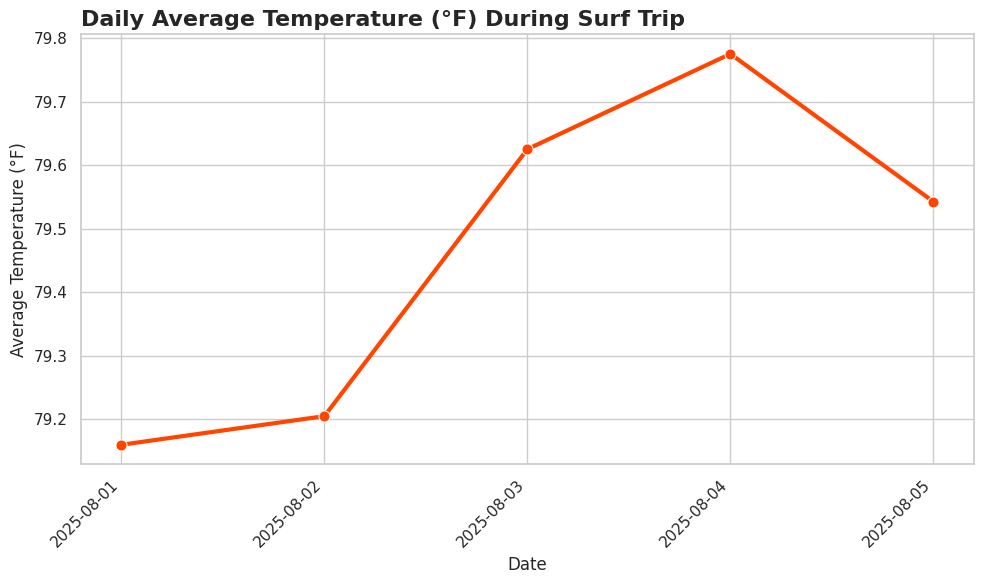

In [55]:
plt.figure(figsize=(10, 6))

sns.lineplot(
    x='date_only',
    y='temperature_2m_mean',
    data=daily_df,
    marker='o',
    markersize=8,
    color='orangered',  # A good, vibrant color for warmth
    linewidth=3
)

# Add informative title and axis labels
plt.title(
    'Daily Average Temperature (°F) During Surf Trip',
    fontsize=16,
    fontweight='bold',
    loc='left'
)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Temperature (°F)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout() # Adjust layout to prevent labels from overlapping

plt.show()

# Current Swell Conditions During Trip

In [56]:
# try it for just Kuta Beach
marine_data = get_marine_weather(lat = -8.718493, lng = 115.168632)

In [57]:
for k,v in marine_data.items():
  print(f"{k}: {v}")

time_utc_unix: 1759574700
time_local: 2025-10-04T10:45:00
wave_height: 5.774278163909912
swell_wave_height: 5.7086615562438965
sea_surface_temp: 84.46999931335449
wave_period_s: 13.649999618530273
sea_level_height_msl: 2.887139081954956


In [58]:
df['current_swell_conditions'] = df.apply(lambda row: get_marine_weather(lat = row['lat'], lng = row['lng']), axis = 1)

In [59]:
df

,day_number,surf_spot,average_ocean_temperature,non_surfing_activity,dinner_recommendation,sources,lat,lng,location_name,current_swell_conditions
0,1,Kuta Beach,81,"Settle into your accommodation, explore the im...","Casual dinner at a local Warung (e.g., Warung ...",['https://seatemperature.info/bali-water-tempe...,-8.718493,115.168632,Kuta Beach,"{'time_utc_unix': 1759574700, 'time_local': '2..."
1,2,Legian Beach,81,"Visit the majestic Tanah Lot Temple, perched o...",Enjoy classic Balinese and Indonesian dishes a...,['https://seatemperature.info/bali-water-tempe...,-8.703948,115.164736,Legian Beach,"{'time_utc_unix': 1759574700, 'time_local': '2..."
2,3,"Batu Bolong, Canggu",81,"Explore Canggu's vibrant streets, local boutiq...",Savor delicious and affordable local Indonesia...,['https://seatemperature.info/bali-water-tempe...,-8.659482,115.130136,Pantai Batu Bolong,"{'time_utc_unix': 1759574700, 'time_local': '2..."
3,4,"Berawa Beach, Canggu",81,Participate in a hands-on Balinese cooking cla...,Indulge in sizzling pork ribs and enjoy the li...,['https://seatemperature.info/bali-water-tempe...,-8.646397,115.151439,Berawa Beach Indonesian Traditional Healing,"{'time_utc_unix': 1759574700, 'time_local': '2..."
4,5,"Batu Bolong, Canggu",81,"Enjoy some last-minute souvenir shopping, revi...",A relaxed farewell dinner at a family-friendly...,['https://seatemperature.info/bali-water-tempe...,-8.659482,115.130136,Pantai Batu Bolong,"{'time_utc_unix': 1759574700, 'time_local': '2..."


# Map Surf Spots

In [60]:
!pip install folium

In [61]:
def get_wave_color(wave_height):
    """Assigns a color based on wave height intensity."""
    if wave_height < 2.0:
        return 'green'      # Low
    elif 2.0 <= wave_height < 4:
        return 'orange'     # Medium
    else:
        return 'red'        # High

In [62]:
import folium

In [63]:
avg_lat = df['lat'].mean()
avg_long = df['lng'].mean()

m = folium.Map(location=[avg_lat, avg_long], zoom_start=5)

for index, row in df.iterrows():
  # Extract wave height
  wave_height = row['current_swell_conditions']['swell_wave_height']

  color = get_wave_color(wave_height)

  # create pop-up text
  text = f"""
    <b>{row['surf_spot']}</b><hr>
    Wave Height: {wave_height:.2f} m ({wave_height * 3.28:.1f} ft)<br>
    Period: {row['current_swell_conditions']['wave_period_s']:.1f} s
    """

  # Add the CircleMarker to the map
  folium.CircleMarker(
    location=[row['lat'], row['lng']],
    radius=10,  # Size of the marker
    popup=text,
    color=color,
    fill=True,
    fill_color=color,
    fill_opacity=0.7
  ).add_to(m)


In [64]:
# Display map
m